In [1]:
%pylab inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import regularizers
tf.enable_eager_execution() 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = [x.astype('float32')/255.0 for x in [x_train, x_test]]
y_train, y_test = [tf.keras.utils.to_categorical(x) for x in [y_train, y_test]]

In [3]:
def block(x, chan=32, ll=None, bn=False):
  # this can be anything that preserves dimensions
  # the invertibility is outside this
  if ll is None:
    l1 = Conv2D(chan, kernel_size=(3,3), padding='same')
    l2 = Conv2D(chan, kernel_size=(3,3), padding='same')
    if bn:
      l3 = BatchNormalization()
      l4 = BatchNormalization()
      ll = [l1, l2, l3, l4]
    else:
      ll = [l1, l2]
  else:
    if bn:
      l1,l2,l3,l4 = ll
    else:
      l1,l2 = ll
  
  x = l1(x)
  if bn:
    x = l3(x)
  x = ELU()(x)
  x = l2(x)
  if bn:
    x = l4(x)
  x = ELU()(x)
  return x, ll

# invertible functions

def revblock(x1, x2, chan=32):
  f, lf = block(x2, chan)
  y1 = Add()([x1, f])
  g, lg = block(y1, chan)
  y2 = Add()([x2, g])
  return y1, y2, lf+lg

def unrevblock(y1, y2, ll):
  g, _ = block(y1, ll=ll[len(ll)//2:])
  x2 = Subtract()([y2, g])
  f, _ = block(x2, ll=ll[:len(ll)//2])
  x1 = Subtract()([y1, f])
  return x1, x2

def pool(x):
  return Lambda(lambda x: tf.concat([x[:, 0::2, 0::2], x[:, 0::2, 1::2], x[:, 1::2, 0::2], x[:, 1::2, 1::2]], axis=-1))(x)

def unpool(tin):
  _, x, y, chans = tin.shape
  def _unpool(tin):
    p0 = tin[:, :, :, (chans*0)//4:(chans*1)//4]
    p1 = tin[:, :, :, (chans*1)//4:(chans*2)//4]
    p2 = tin[:, :, :, (chans*2)//4:(chans*3)//4]
    p3 = tin[:, :, :, (chans*3)//4:(chans*4)//4]
    p01 = tf.reshape(tf.concat([p0[:, :, :, None], p1[:, :, :, None]], axis=3), (-1, x, y*2, chans//4))
    p23 = tf.reshape(tf.concat([p2[:, :, :, None], p3[:, :, :, None]], axis=3), (-1, x, y*2, chans//4))
    ret = tf.reshape(tf.concat([p01[:, :, None], p23[:, :, None]], axis=2), (-1, x*2, y*2, chans//4))
    return ret
  return Lambda(_unpool)(tin)

In [4]:
# entry
in_dim = (x_train.shape[1], x_train.shape[2])
x = in1 = Input(in_dim)
x = Reshape((28,28,1))(x)
chans = 1
x1, x2 = x, x

# main
x1, x2, l1 = revblock(x1, x2, chans)
x1, x2, l2 = revblock(x1, x2, chans)
x1, x2 = map(pool, [x1,x2])
chans *= 4
x1, x2, l3 = revblock(x1, x2, chans)
x1, x2, l4 = revblock(x1, x2, chans)
x1, x2 = map(pool, [x1,x2])
chans *= 4
x1, x2, l5 = revblock(x1, x2, chans)
x1, x2, l6 = revblock(x1, x2, chans)

# exit
x = Concatenate()([x1,x2])
flat = Flatten(name="hidden")(x)

bad_layer = Dense(2, use_bias=False)
x = bad_layer(flat)   # non reversible

# invertibility loss
invert_layer = Lambda(lambda x: tf.matmul(x, tf.transpose(bad_layer.weights[0])))
invert_layer_out = invert_layer(x)

m = Model(in1, x)
def loss(y_true, y_pred):
  loss = tf.nn.softmax_cross_entropy_with_logits(logits=y_true,labels= y_pred)
  revloss = tf.reduce_mean((invert_layer_out - flat)**2, axis=-1)
  return loss + revloss
m.compile('adam', loss, metrics=['accuracy'])

rev = Model(m.inputs,[m.get_layer('hidden').output])
rev.compile('sgd', 'mse')

# invert
x = in1 = Input((np.product(in_dim)*2,))
x = Reshape((x_train.shape[1]//4,x_train.shape[2]//4,chans*2))(x)
x1 = Lambda(lambda x: x[:, :, :, :chans])(x)
x2 = Lambda(lambda x: x[:, :, :, chans:])(x)

# inverted main
x1, x2 = unrevblock(x1, x2, l6)
x1, x2 = unrevblock(x1, x2, l5)
x1, x2 = map(unpool, [x1,x2])
x1, x2 = unrevblock(x1, x2, l4)
x1, x2 = unrevblock(x1, x2, l3)
x1, x2 = map(unpool, [x1,x2])
x1, x2 = unrevblock(x1, x2, l2)
x1, x2 = unrevblock(x1, x2, l1)

# exit
x1, x2 = map(Reshape(x_train.shape[1:]), [x1,x2])
unrev = Model(in1, [x1,x2])
unrev.compile('sgd', 'mse')

# autoencoder loss
in_dim = (x_train.shape[1], x_train.shape[2])
x = in1 = Input(in_dim)
x = rev(x)
x = bad_layer(x)
x = invert_layer(x)
x1, x2 = unrev(x)

ae = Model(in1, [x1,x2])
ae.compile('adam', ['mse', 'mse'])

W0821 10:02:24.251427 140042096482112 deprecation.py:323] From <ipython-input-4-f504f5874cf2>:33: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [5]:
ae.fit(x_train, [x_train, x_train],
       validation_data=(x_test, [x_test, x_test]),
       batch_size=256, epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 274us/sample - loss: 0.1444 - model_2_loss: 0.0729 - model_2_1_loss: 0.0714 - val_loss: 0.1207 - val_model_2_loss: 0.0609 - val_model_2_1_loss: 0.0601
Epoch 2/20
60000/60000 [==============================] - 13s 213us/sample - loss: 0.1187 - model_2_loss: 0.0595 - model_2_1_loss: 0.0592 - val_loss: 0.1173 - val_model_2_loss: 0.0587 - val_model_2_1_loss: 0.0585
Epoch 3/20
60000/60000 [==============================] - 13s 212us/sample - loss: 0.1160 - model_2_loss: 0.0581 - model_2_1_loss: 0.0579 - val_loss: 0.1148 - val_model_2_loss: 0.0575 - val_model_2_1_loss: 0.0572
Epoch 4/20
60000/60000 [==============================] - 13s 214us/sample - loss: 0.1133 - model_2_loss: 0.0568 - model_2_1_loss: 0.0566 - val_loss: 0.1116 - val_model_2_loss: 0.0557 - val_model_2_1_loss: 0.0555
Epoch 5/20
60000/60000 [==============================] - 13s 213us/sample - loss: 0.1105 - model_

8.34465e-07 1.5944242e-06 1.8551946e-06


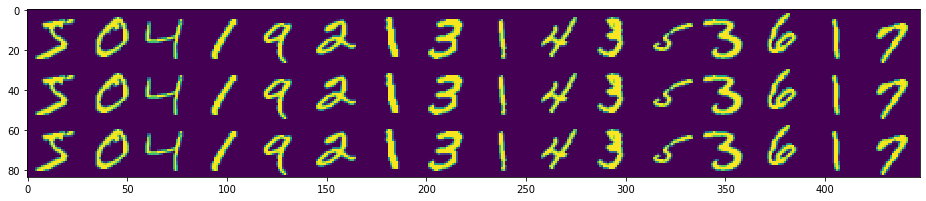

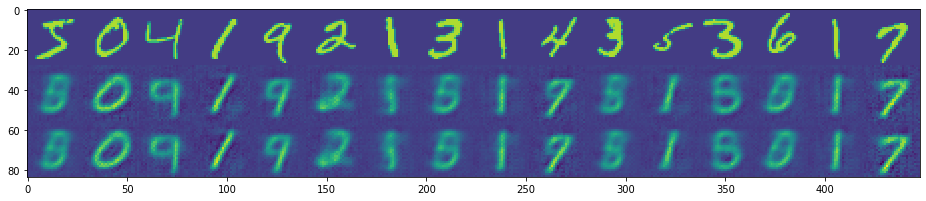

In [8]:

# test reversibility
tol = 1e-4
x_train_in = x_train[0:16]
mid = rev.predict(x_train_in)
x_train_xx_0, x_train_xx_1 = unrev.predict(mid)
print(np.max(np.abs(x_train_xx_1 - x_train_xx_0)),
      np.max(np.abs(x_train_in - x_train_xx_0)),
      np.max(np.abs(x_train_in - x_train_xx_1)))
assert np.allclose(x_train_xx_0, x_train_xx_1, atol=tol)
assert np.allclose(x_train_in, x_train_xx_0, atol=tol)
assert np.allclose(x_train_in, x_train_xx_1, atol=tol)
figsize(16,16)
imshow(np.concatenate([
  np.concatenate(x_train_in, axis=1),
  np.concatenate(x_train_xx_0, axis=1),
  np.concatenate(x_train_xx_1, axis=1)
], axis=0))

# through the autoencoder layer
figure()
xx = np.matmul(mid, bad_layer.weights[0].numpy())
xx = np.matmul(xx, bad_layer.weights[0].numpy().T)
xx_0, xx_1 = unrev.predict(xx)
imshow(np.concatenate([
  np.concatenate(x_train_in, axis=1),
  np.concatenate(xx_0, axis=1),
  np.concatenate(xx_1, axis=1)
], axis=0))

60000/60000 [==============================] - 2s 34us/sample


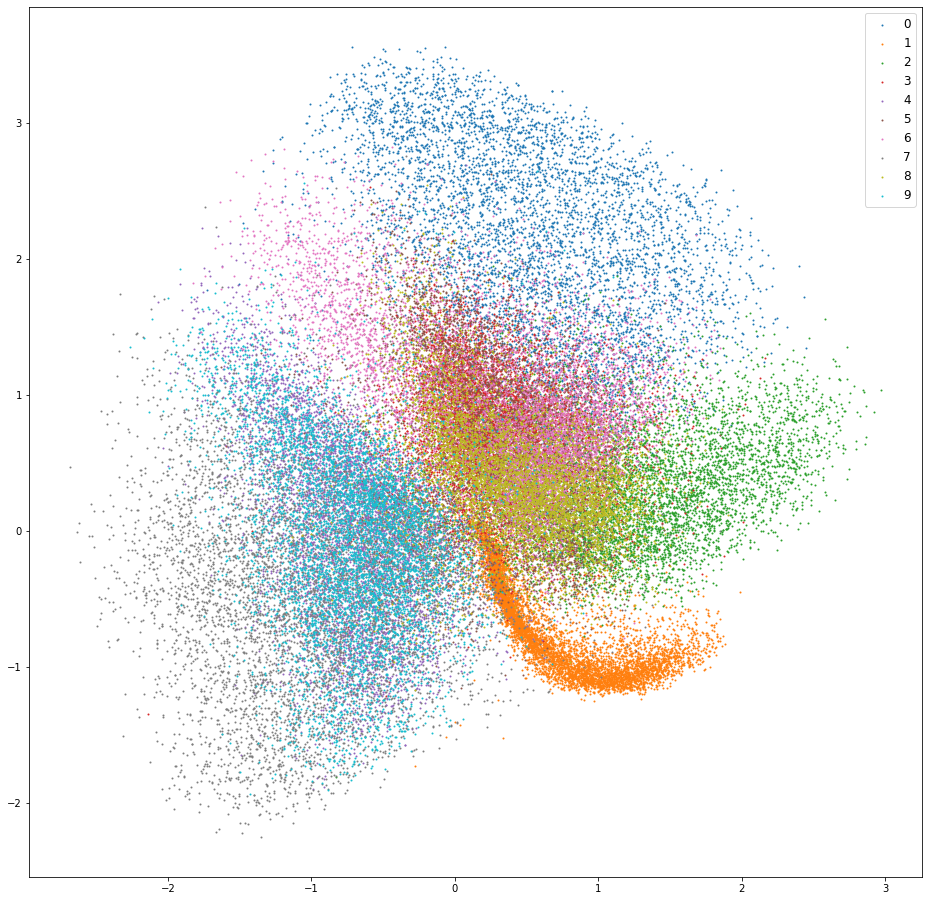

In [9]:
mid = rev.predict(x_train, verbose=1, batch_size=1024)
xx = np.matmul(mid, bad_layer.weights[0].numpy())

for i in range(10):
  ll = xx[y_train[:, i] == 1]
  plt.scatter(ll[:, 0], ll[:, 1], s=1.0)
plt.legend(['%d' % x for x in range(10)], fontsize='large')